***Question 1 SSolution***

In [1]:
import json
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import jmespath

**Probe Selector:**
This method reads from the probes.json file. This file contains the information about the probes for 10th February. This probe selector applies the required filters
 and selects from these probes. After the selection phase, it generates a plot containing these probes and also the datacenters chosen prior.

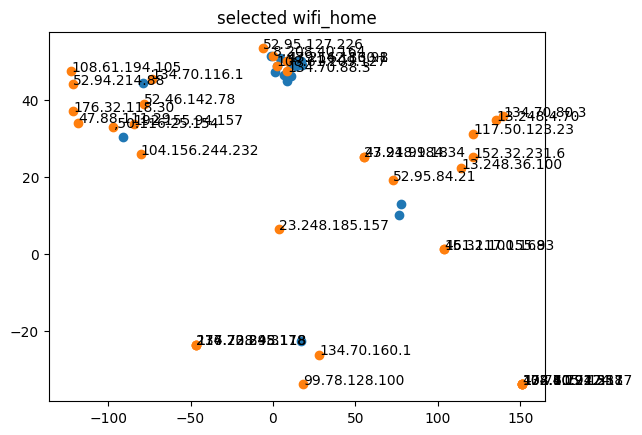

wifi_home
19
19


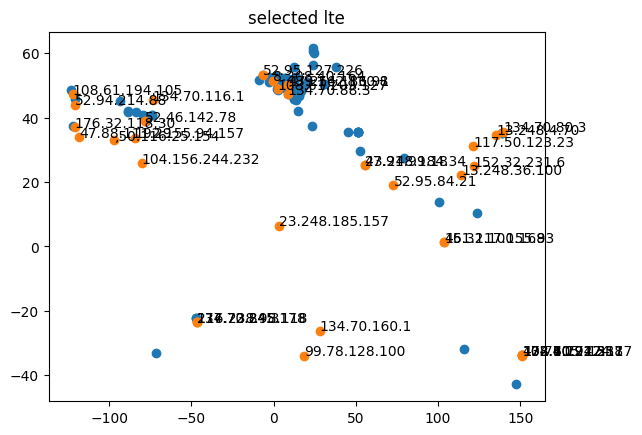

lte
74
74


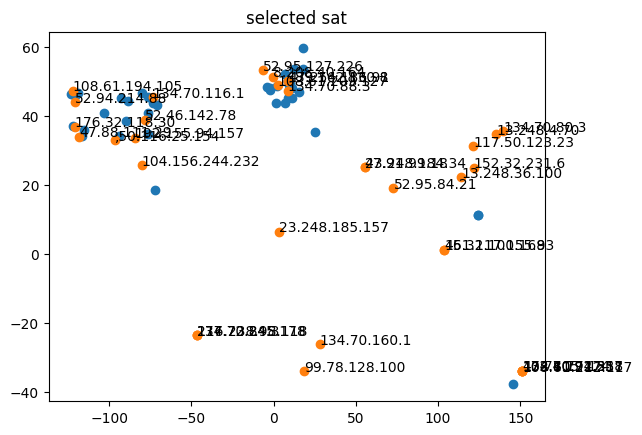

sat
39
39


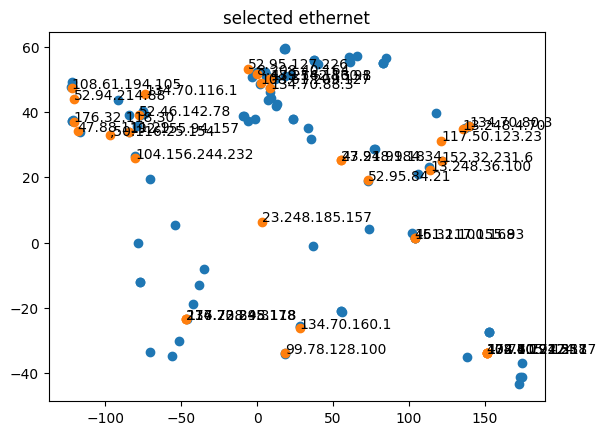

ethernet
100
100


In [2]:
probe_dict = {
    'wifi_home': {
        'query': "contains(tags, 'home') && "
                 "(contains(tags, 'wi-fi') || contains(tags, 'wifi') || "
                 "contains(tags, 'wlan') || contains(tags, 'wireless') || "
                 "contains(tags, 'wireless-link')) && "
                 "!(contains(tags, 'lte') || contains(tags, '5g') || "
                 "contains(tags, '4g') || contains(tags, '3g') || "
                 "contains(tags, 'cellular')) && "
                 "!(contains(tags, 'dsl') || contains(tags, 'adsl') || "
                 "contains(tags, 'fibre') || contains(tags, 'fiber') || "
                 "contains(tags, 'cable'))",
        'file_json': "./wifi_home_probes.json",
        'file_100_json': "./wifi_home_probes_{}.json",
        'file_100_csv': "./wifi_home_probes_ids_{}.csv"
    },
    'lte': {
        'query': "(contains(tags, 'lte') || contains(tags, '5g') || "
                 "contains(tags, '4g') || contains(tags, '3g') || "
                 "contains(tags, 'cellular')) && "
                 "!(contains(tags, 'wi-fi') || contains(tags, 'wifi') || "
                 "contains(tags, 'wlan') || contains(tags, 'wireless') || "
                 "contains(tags, 'wireless-link') || contains(tags, 'home') || "
                 "contains(tags, 'fibre'))",
        'file_json': "./lte_probes.json",
        'file_100_json': "./lte_probes_{}.json",
        'file_100_csv': "./lte_probes_ids_{}.csv"
    },
    'sat': {
        'query': "asn_v4 == to_number('14593') && contains(tags, 'starlink')",
        'file_json': "./sat_probes.json",
        'file_100_json': "./sat_probes_{}.json",
        'file_100_csv': "./sat_probes_ids_{}.csv"
    },
    'ethernet': {
        'query': "contains(tags, 'home') && "
                 "(contains(tags, 'dsl') || contains(tags, 'adsl') || "
                 "contains(tags, 'fibre') || contains(tags, 'fiber') || "
                 "contains(tags, 'cable')) && "
                 "!(contains(tags, 'lte') || contains(tags, '5g') || "
                 "contains(tags, '4g') || contains(tags, '3g') ||"
                 "contains(tags, 'cellular')) && "
                 "!(contains(tags, 'wi-fi') || contains(tags, 'wifi') || "
                 "contains(tags, 'wlan') || contains(tags, 'wireless') || "
                 "contains(tags, 'wireless-link'))",
        'file_json': "./ethernet_probes.json",
        'file_100_json': "./ethernet_probes_{}.json",
        'file_100_csv': "./ethernet_probes_ids_{}.csv"
    },
}


def probe_selector():
    with open('./probes.json', 'r') as r_file:
        probe_data = json.load(r_file)
        for probe_dict_k, probe_dict_v in probe_dict.items():
            # query probes with type
            filtered_probes = jmespath.search(f"objects[?({probe_dict_v['query']}) "
                                              f"&& status_name == 'Connected' && status == to_number('1')]",
                                              probe_data)
            # generate clusters of probes
            filtered_probes_long = [p['longitude'] for p in filtered_probes]
            filtered_probes_lat = [p['latitude'] for p in filtered_probes]
            cord = list(zip(filtered_probes_long, filtered_probes_lat))
            kmeans = KMeans(n_clusters=min(25, len(filtered_probes_lat)))
            kmeans.fit(cord)
            # display cluster plots
            # plt.scatter(filtered_probes_long, filtered_probes_lat, c=kmeans.labels_)
            # plt.title(probe_dict_k)
            # plt.show()
            # create probe records
            with open(probe_dict_v['file_json'], 'w') as w_file:
                w_file.write(json.dumps(filtered_probes))
            # select probes
            n_no_probes = []
            n_no_probes_ids = []
            if len(filtered_probes) <= 100:
                n_no_probes = filtered_probes
                n_no_probes_ids = [str(p['id']) for p in filtered_probes]
            else:
                # select from clusters
                cluster_dict = {}
                len_probes = len(filtered_probes)
                # prepare dictionary of clusters
                for i in range(len_probes):
                    if kmeans.labels_[i] not in cluster_dict:
                        cluster_dict[kmeans.labels_[i]] = []
                    cluster_dict[kmeans.labels_[i]].append(filtered_probes[i])
                # equally select from clusters
                ind_counter = 0
                while True:
                    for _, cluster_dict_v in cluster_dict.items():
                        if len(n_no_probes) >= 100:
                            break
                        if len(cluster_dict_v) > ind_counter:
                            el = cluster_dict_v[ind_counter]
                            n_no_probes.append(el)
                            n_no_probes_ids.append(str(el['id']))
                    ind_counter += 1
                    if len(n_no_probes) >= 100:
                        break

            # create selected probes json
            with open(probe_dict_v['file_100_json'].format(len(n_no_probes)), 'w') as w_file:
                w_file.write(json.dumps(n_no_probes))
            # create selected probes ids csv
            with open(probe_dict_v['file_100_csv'].format(len(n_no_probes)), 'w') as w_file:
                w_file.write(",".join(n_no_probes_ids))
            # display selected probes plots
            selected_probes_long = [pr['longitude'] for pr in n_no_probes]
            selected_probes_lat = [pr['latitude'] for pr in n_no_probes]
            plt.scatter(selected_probes_long, selected_probes_lat)
            # for i, txt in enumerate(n_no_probes_ids):
            #     plt.annotate(txt, (selected_probes_long[i], selected_probes_lat[i]), color='r')

            datacenter_locations = [[-78, 39, '52.46.142.78'], [-121, 37, '176.32.118.30'], [-121, 44, '52.94.214.88'],
                                    [114.1577, 22.2855, '13.248.36.100'], [72.8774, 19.0760, '52.95.84.21'],
                                    [135.5022, 34.6942, '13.248.4.70'], [18.4229, -33.9256, '99.78.128.100'],
                                    [-46.6372, -23.5471, '177.72.245.178'], [-6.2672, 53.3442, '52.95.127.226'],
                                    [151.2070, -33.8678, '103.8.174.238'], [-0.1257, 51.5085, '8.208.40.164'],
                                    [55.3047, 25.2585, '47.91.99.18'], [151.2070, -33.8678, '47.74.79.155'],
                                    [103.8503, 1.2900, '161.117.155.93'],
                                    [8.6820, 50.1109, '47.254.186.91'], [-118.2439, 34.0526, '47.88.111.29'],
                                    [-122.2348, 47.3809, '108.61.194.105'], [-80.2364, 25.8118, '104.156.244.232'],
                                    [-46.6372, -23.5471, '216.238.98.118'], [2.3843, 48.9165, '108.61.209.127'],
                                    [103.8503, 1.2900, '45.32.100.168'], [151.2003, -33.9022, '108.61.212.117'],
                                    [-84.3875, 33.7488, '192.155.94.157'], [-96.7298, 32.9483, ',50.116.25.154'],
                                    [8.6820, 50.1109, '139.162.130.8'], [151.2070, -33.8678, '172.105.174.7'],
                                    [121.5636, 25.0382, '152.32.231.6'], [3.3958, 6.4530, '23.248.185.157'],
                                    [55.3047, 25.2585, '23.248.184.34'], [121.4689, 31.2243, '117.50.123.23'],
                                    [151.2070, -33.8678, '134.70.92.3'], [-46.6372, -23.5471, '134.70.84.3'],
                                    [139.6923, 35.6895, '134.70.80.3'], [8.5498, 47.3668, '134.70.88.3'],
                                    [-73.5878, 45.5088, '134.70.116.1'], [28.0436, -26.2022, '134.70.160.1']]
            datacenter_long = [el[0] for el in datacenter_locations]
            datacenter_lat = [el[1] for el in datacenter_locations]
            datacenter_ips = [el[2] for el in datacenter_locations]
            plt.scatter(datacenter_long, datacenter_lat)
            for i, txt in enumerate(datacenter_ips):
                plt.annotate(txt, (datacenter_long[i], datacenter_lat[i]))
            plt.title("selected " + probe_dict_k)
            plt.show()
            print(probe_dict_k)
            print(len(n_no_probes))
            print(len(n_no_probes_ids))

probe_selector()

**Probe Cord Filter:**
Reads from the filtered probes files and prints (to the terminal) the probes and the datacenters which are located in the given latitude and magnitudes as coma seperated values. IDs of probes and IPs of datacenters are printed.
*Note: Please do not run before probe_selector function*

In [3]:
json_files = ['./ethernet_probes_100.json', './lte_probes_74.json',
              './sat_probes_39.json', './wifi_home_probes_19.json']


def probe_cord_filter(low_long, up_long, low_lat, up_lat):
    for f in json_files:
        with open(f, 'r') as r_file:
            probe_data = json.load(r_file)
            filtered_probes = jmespath.search(f"[?latitude >= to_number('{low_lat}') &&"
                                              f" latitude < to_number('{up_lat}') && "
                                              f"longitude >= to_number('{low_long}') && "
                                              f"longitude < to_number('{up_long}')].id"
                                              , probe_data)
            str_filtered_probes = [str(el) for el in filtered_probes]
            print(f)
            print(', '.join(str_filtered_probes))

    def is_in_range_cords(el):
        return low_long <= el[0] < up_long and low_lat <= el[1] < up_lat

    datacenter_locations = [[-78, 39, '52.46.142.78'], [-121, 37, '176.32.118.30'], [-121, 44, '52.94.214.88'],
                            [114.1577, 22.2855, '13.248.36.100'], [72.8774, 19.0760, '52.95.84.21'],
                            [135.5022, 34.6942, '13.248.4.70'], [18.4229, -33.9256, '99.78.128.100'],
                            [-46.6372, -23.5471, '177.72.245.178'], [-6.2672, 53.3442, '52.95.127.226'],
                            [151.2070, -33.8678, '103.8.174.238'], [-0.1257, 51.5085, '8.208.40.164'],
                            [55.3047, 25.2585, '47.91.99.18'], [151.2070, -33.8678, '47.74.79.155'],
                            [103.8503, 1.2900, '161.117.155.93'],
                            [8.6820, 50.1109, '47.254.186.91'], [-118.2439, 34.0526, '47.88.111.29'],
                            [-122.2348, 47.3809, '108.61.194.105'], [-80.2364, 25.8118, '104.156.244.232'],
                            [-46.6372, -23.5471, '216.238.98.118'], [2.3843, 48.9165, '108.61.209.127'],
                            [103.8503, 1.2900, '45.32.100.168'], [151.2003, -33.9022, '108.61.212.117'],
                            [-84.3875, 33.7488, '192.155.94.157'], [-96.7298, 32.9483, ',50.116.25.154'],
                            [8.6820, 50.1109, '139.162.130.8'], [151.2070, -33.8678, '172.105.174.7'],
                            [121.5636, 25.0382, '152.32.231.6'], [3.3958, 6.4530, '23.248.185.157'],
                            [55.3047, 25.2585, '23.248.184.34'], [121.4689, 31.2243, '117.50.123.23'],
                            [151.2070, -33.8678, '134.70.92.3'], [-46.6372, -23.5471, '134.70.84.3'],
                            [139.6923, 35.6895, '134.70.80.3'], [8.5498, 47.3668, '134.70.88.3'],
                            [-73.5878, 45.5088, '134.70.116.1'], [28.0436, -26.2022, '134.70.160.1']]
    filtered_datacenters = filter(is_in_range_cords, datacenter_locations)
    filtered_data_center_targets = [el[2] for el in filtered_datacenters]
    print("Target IPs")
    print(', '.join(filtered_data_center_targets))

### These coordinates are given as examples
LOW_LONG = -10
UP_LONG = 10
LOW_LAT = 45
UP_LAT = 60
probe_cord_filter(LOW_LONG, UP_LONG, LOW_LAT, UP_LAT)

./ethernet_probes_100.json
1, 60, 157, 7, 430, 8, 471, 453, 18, 761
./lte_probes_74.json
13308, 14895, 26320, 26869, 31382, 50081, 50640, 51136, 52740, 53064, 55293, 55677, 55795, 60200, 61321, 63015, 63046, 1003425, 1005061, 1005072, 1006693, 1006700
./sat_probes_39.json
16869, 26380, 30326, 32686, 1004353, 1004876, 1006382, 1006857
./wifi_home_probes_19.json
11268, 13615, 1001151, 1005825, 1005913
Target IPs
52.95.127.226, 8.208.40.164, 47.254.186.91, 108.61.209.127, 139.162.130.8, 134.70.88.3
